In [1]:
# This notebook is optimized to run on a gpu instance of Amazon Sagemaker.

In [2]:
# imports

# All of these modules are either included in the code base
# or provided by default on Amazon Sagemaker. 

import gc
import glob
import json
import math
import os
import pickle
import pprint
import random
import time
from collections import Counter
from pathlib import Path
from time import gmtime, strftime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from db import NABat_DB
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model


In [3]:

# Print tensorflow version and whether we have access to a gpu.
print(tf.__version__)
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set the random seed for repeatability.
seed = 546
random.seed(seed)

# Create a place to store our trained models.
try:
    os.mkdir('models')
except:
    pass

2.10.0
Number of GPUs Available:  0


In [4]:
db = NABat_DB()

# Point to a directory of species codes containing .wav files. 
# Example "../v1.1.0/data/wav/ANPA/p163_g89522_f28390444.wav"
directory = '../Downloads/data/wav'


# Make sure there are at least 3 example files for each class we want to include.
sample_classes = []
x = [c.split('/')[-1] for c in glob.glob('{}/*'.format(directory), recursive=True)]
for c in x:
    size = len(glob.glob('{}/{}/*'.format(directory, c), recursive=True))
    if size > 40:
        sample_classes.append(c)
        
# Alphibitize.
sample_classes.sort()

# Print the classes we will include.
pprint.pprint(sample_classes)

# Set the database flag describing which species classes will be considered 
# in this model training run.
db.insert('update species set available = 0') 
for s in sample_classes:
    db.insert('update species set available = 1 where species_code = ?',(s,)) 

db.conn.close()


['ANPA',
 'COTO',
 'EPFU',
 'EUPE',
 'IDPH',
 'LABL',
 'LABO',
 'LACI',
 'LAIN',
 'LANO',
 'LASE',
 'MYAU',
 'MYCA',
 'MYCI',
 'MYEV',
 'MYGR',
 'MYLE',
 'MYLU',
 'MYSE',
 'MYSO',
 'MYTH',
 'MYVO',
 'MYYU',
 'NOISE',
 'NYHU',
 'NYMA',
 'PAHE',
 'PESU',
 'TABR']


In [5]:

# Keep this connection open for the life of this model training run.
db = NABat_DB()

# Return a list of files belonging to a dataset. 'train', 'test', or 'validate'.
def get_files(draw):
    return db.query('select id, name, grts_id from file where draw = ? and grts_id != 0 order by id',(draw,))

# Return list of bat pulses that originated from a given recording file, by file id.
def get_pulses(file_id):
    return db.query('select * from pulse where file_id = ? order by id',(file_id,))

# Yield a spectrogram image and the class it belongs to. 
def image_generator(draw):
    try:
        draw = draw.decode("utf-8")
    except:
        pass
    
    # Get list of files.
    files = get_files(draw)
    for f in files:
        species = f.name.split('-')[0]
        if species in sample_classes:
            species_id = sample_classes.index(species)
            
            # Get a list of pulses (and path to associated spectrogram image on disk) belonging to file.
            metadata = get_pulses(f.id)
            
            for i, m in enumerate(metadata):
                # Normalize the image so that each pixel value
                # is scaled between 0 and 1.
                image = Image.open(m.path)
                img = np.array(image)
                img = img[..., :3].astype('float32')
                img /= 255.0
                image.close()
                yield {"input_1": img}, species_id



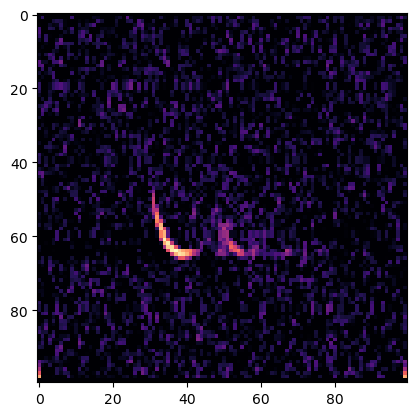

In [7]:
# Test the image generator function.
gen = image_generator('test')
plt.imshow(next(gen)[0]['input_1'])


In [8]:
# Define the batch size for the network.
batch_size = 32

# Create a training dataset.
train_dataset = tf.data.Dataset.from_generator(
    image_generator, args=['train'],
    output_types=({"input_1": tf.float16}, tf.int32),
    output_shapes=({"input_1": (100,100,3)}, () )                                      
    ).batch(batch_size).prefetch(1000)

# Create a validation dataset.
validation_dataset = tf.data.Dataset.from_generator(
    image_generator, args=['validate'],
    output_types=({"input_1": tf.float16}, tf.int32),
    output_shapes=({"input_1": (100,100,3)}, () )                                      
    ).batch(batch_size).prefetch(1000)


In [ ]:

# Save the metadata for the current model run.
with open('models/training_history_{}.p'.format('0'), 'wb') as fp:

    # Define model inputs.
    inputs = layers.Input(shape=(100,100,3))

    # Define network shape.
    w = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    w = layers.Dropout(0.2)(w)
    w = layers.MaxPooling2D(padding='same')(w)
    w = layers.Conv2D(64, 3, activation='relu', padding='same')(w)
    w = layers.Conv2D(64, 3, activation='relu', padding='same')(w)
    w = layers.Dropout(0.2)(w)
    w = layers.MaxPooling2D(padding='same')(w)
    w = layers.Conv2D(128, 3, activation='relu', padding='same')(w)
    w = layers.Conv2D(128, 3, activation='relu', padding='same')(w)
    w = layers.Conv2D(128, 3, activation='relu', padding='same')(w)
    w = layers.Dropout(0.2)(w)
    w = layers.MaxPooling2D(padding='same')(w)
    w = layers.Flatten()(w)
    w = layers.Dropout(0.4)(w)
    w = layers.Dense(256, activation='relu')(w)
    w = layers.Dropout(0.4)(w)
    w = layers.Dense(256, activation='relu')(w)
    w = layers.Dropout(0.4)(w)
    w = layers.Dense(256, activation="relu")(w)
    w = layers.Dense(len(sample_classes), activation="softmax")(w)
   
    model = Model(inputs=inputs, outputs=w)
    
    # Print and plot network.
    model.summary()
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    # Set the hyperparameters for this model run.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9,
                                        beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                        name='Adam'
                                        ),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy']
        )

    # Define the early stopping criteria.
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

    # Start the training. This will produce a preliminary (course) model.
    h = model.fit(train_dataset,
                validation_data=validation_dataset,
                epochs=25,
                verbose=1,
                callbacks=[es]
        )

    # Save the metadata, model, and weights to disk.
    model.save('models/m-{}'.format('0'))
    pickle.dump((h.history, sample_classes), fp)


In [ ]:

# Reopen the same model for further training.
# Here we reduce the learning rate hyperparameter by a factor of 100
# to fine-tune the model.

with open('models/training_history_{}.p'.format('1'), 'wb') as fp:

    model = keras.models.load_model('models/m-{}'.format('0'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.9,
                                        beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                        name='Adam'
                                        ),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy']
        )


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

    h = model.fit(train_dataset,
                validation_data=validation_dataset,
                epochs=50,
                verbose=1,
                callbacks=[es]
        )

    model.save('models/m-{}'.format('1'))
    pickle.dump((h.history, sample_classes), fp)




In [ ]:

# Optional, plot the accuracy and loss curves of the training and validation sets.
def plot_training():
    
    epochs_range = range(40)
    plt.figure(figsize=(16, 12))
    
    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid()
    for i in range(0,99,1):
        try:
            with open('models/training_history_{}.p'.format(i), 'rb') as fp:
                m = pickle.load(fp)[0]
                acc = m['accuracy'] + ([0] * (epochs_range[-1] - len(m['accuracy'])))
                val_acc = m['val_accuracy'] + ([float('nan')] * (epochs_range[-1] - len(m['val_accuracy'])))
                
                plt.plot(epochs_range[:-1], acc, label='Training Accuracy {}'.format(i))
                plt.plot(epochs_range[:-1], val_acc, label='Validation Accuracy {}'.format(i))
    
        except Exception as e:
            pass
        
    plt.legend(loc='lower right')

        
    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    for i in range(0,99,1):
        try:
            with open('models/training_history_{}.p'.format(i), 'rb') as fp:
                m = pickle.load(fp)[0]
                loss = m['loss'] + ([0] * (epochs_range[-1] - len(m['loss'])))
                val_loss = m['val_loss']
                val_loss += ([float('nan')] * (epochs_range[-1] - len(m['val_loss'])))
                
                plt.plot(epochs_range[:-1], loss, label='Training Loss {}'.format(i))
                plt.plot(epochs_range[:-1], val_loss, label='Validation Loss {}'.format(i))
    
        except Exception as e:
            pass
    
    plt.legend(loc='upper right')
    plt.show()

    
plot_training()


In [ ]:

# Get available information for species.
species = db.query('select * from species;')

# Get the index of the species in the model output from the species code.
def get_species_index(species_code):
    for i, s in enumerate(species):
        if s.species_code == species_code:
            return i

# Define a new test generator that will represent the pulse id instead
# of the species id, since we want to predict the latter.
def test_generator(draw):
    try:
        draw = draw.decode("utf-8")
    except:
        pass
    files = get_files(draw)
    for f in files:
        species = f.name.split('-')[0]
        s_index = get_species_index(species)
        if species in sample_classes:
            species_id = sample_classes.index(species)
            metadata = get_pulses(f.id)
            for i, m in enumerate(metadata):
                image = Image.open(m.path)
                img = np.array(image)
                img = img[..., :3].astype('float32')
                img /= 255.0
                image.close()
                yield {"input_1": img}, m.id
                

In [ ]:

# Define the tuned model.
m = '1'
dir_path = os.getcwd()


# Insert a set of predictions into the database.
def insert(data):
    db.conn.executemany(
        "insert into prediction (model_name, pulse_id, confidence, species_id) values (?,?,?,?);", data)
    db.conn.execute('commit;')


# Given a species code, return a numeric id.
def get_manual_id(species_code):
    for s in species:
        if s.species_code == species_code:
            return s.id

# Load the tuned model from disk.
model = keras.models.load_model('models/m-{}'.format(m))


# Provide a prediction for each pulse in the test set.
to_predict1 = []
ids = []
data = []
count = 0
for p in test_generator('test'):     
    count += 1
    to_predict1.append(p[0]['input_1'])
    ids.append(p[1])
    
    # Batch the predictions into groupes of 1024.
    if count != 0 and (count % 1024 == 0 ):
        predictions = model.predict([to_predict1],batch_size=1024)
        for x, prediction in enumerate(predictions):
            for i, c in enumerate(prediction):
                data.append((str(m), ids[x], float(c), get_manual_id(sample_classes[i])))
        
        insert(data)
        to_predict1 = []
        data = []
        ids = []
        
        # Clean up
        gc.collect()
        
        # Report progress.
        print('{}'.format(int(count)))

# Predict the remaining < 1024 predictions not batched in prior step.
predictions = model.predict([to_predict1],batch_size=len(ids))
for x, prediction in enumerate(predictions):
    for i, c in enumerate(prediction):
        data.append((str(m), ids[x], float(c), get_manual_id(sample_classes[i])))
insert(data)